###Installed Required Libraries

In [ ]:
!pip install torch torchvision datasets transformers scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

###Imported Necessary Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.manifold import TSNE
from scipy.stats import mode

###Loaded Fashion MNIST Dataset from HuggingFace Manually

In [ ]:
splits = {'train': 'fashion_mnist/train-00000-of-00001.parquet',
          'test': 'fashion_mnist/test-00000-of-00001.parquet'}

df = pd.read_parquet("hf://datasets/zalando-datasets/fashion_mnist/" + splits["train"])
df.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,image,label
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,9
1,"{'bytes': b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...",0
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,3
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0


###Data Processing: Convert Image Bytes to NumPy Arrays

In [ ]:
from PIL import Image
import io

def decode_image(example):
    return np.array(Image.open(io.BytesIO(example['bytes'])))

X = np.stack([decode_image(row) for row in df['image']])
X = X.reshape(len(X), -1).astype("float32") / 255.0  # Normalize to (0, 1)
y = df['label'].to_numpy()

###Autoencoder Model

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

###Training Loop

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)

train_loader = DataLoader(TensorDataset(torch.tensor(X)), batch_size=128, shuffle=True)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(20):
    total_loss = 0
    for batch in train_loader:
        x_batch = batch[0].to(device).float()
        output = model(x_batch)
        loss = criterion(output, x_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/20, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1/20, Loss: 0.0445
Epoch 2/20, Loss: 0.0237
Epoch 3/20, Loss: 0.0203
Epoch 4/20, Loss: 0.0189
Epoch 5/20, Loss: 0.0181
Epoch 6/20, Loss: 0.0172
Epoch 7/20, Loss: 0.0164
Epoch 8/20, Loss: 0.0158
Epoch 9/20, Loss: 0.0153
Epoch 10/20, Loss: 0.0148
Epoch 11/20, Loss: 0.0144
Epoch 12/20, Loss: 0.0140
Epoch 13/20, Loss: 0.0138
Epoch 14/20, Loss: 0.0135
Epoch 15/20, Loss: 0.0133
Epoch 16/20, Loss: 0.0131
Epoch 17/20, Loss: 0.0129
Epoch 18/20, Loss: 0.0127
Epoch 19/20, Loss: 0.0126
Epoch 20/20, Loss: 0.0124


###K-means Clustering

In [ ]:
model.eval()
with torch.no_grad():
    compressed = model.encoder(torch.tensor(X).to(device).float()).cpu().numpy()
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(compressed)

###Purity & Silhouette Score

In [ ]:
def purity_score(y_true, y_pred):
    labels = np.zeros_like(y_pred)
    for i in range(10):
        mask = (y_pred == i)
        if np.any(mask):
            labels[mask] = mode(y_true[mask])[0]
    return accuracy_score(y_true, labels)

purity = purity_score(y, cluster_labels)
print(f"Purity Score: {purity:.4f}")
print("Silhouette Score:", silhouette_score(compressed, cluster_labels))

Purity Score: 0.5063
Silhouette Score: 0.21153018


###Adjusted Rand Index (ARI)

In [ ]:
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(y, cluster_labels)
print(f"Adjusted Rand Index: {ari:.4f}")

Adjusted Rand Index: 0.2883


###Normalized Mutual Information (NMI)

In [ ]:
from sklearn.metrics import normalized_mutual_info_score
nmi = normalized_mutual_info_score(y, cluster_labels)
print(f"Normalized Mutual Information: {nmi:.4f}")

Normalized Mutual Information: 0.4881


###Confusion Matrix

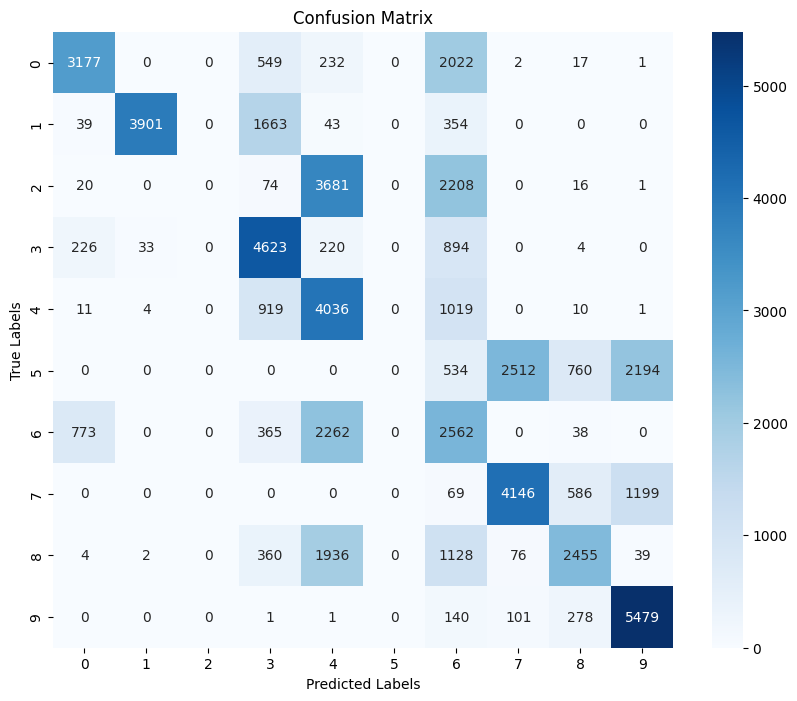

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

mapped_labels = np.zeros_like(cluster_labels)
for i in range(10):
    mask = (cluster_labels == i)
    if np.any(mask):
        mapped_labels[mask] = mode(y[mask])[0]

conf_mat = confusion_matrix(y, mapped_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

###Cluster Visualization using t-SNE

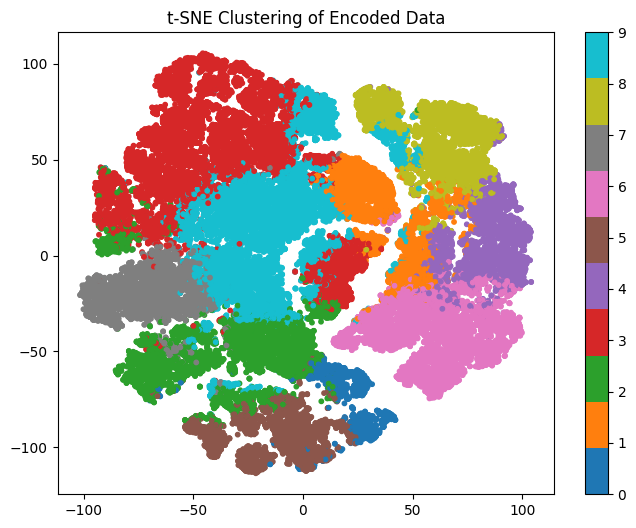

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(compressed)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.title("t-SNE Clustering of Encoded Data")
plt.colorbar()
plt.show()